In [34]:
import csv
import numpy as np
from tkinter import *
from matplotlib.figure import Figure
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import matplotlib.pyplot as plt

In [35]:
# Replace 'your_file.csv' with the actual path to your CSV file
csv_file_path = 'Q1 - Eye_data.csv'

# Create a dictionary to store the values
data_list = []

# Read the CSV file
with open(csv_file_path, 'r') as file:
    csv_reader = csv.reader(file)
    # Iterate through each row in the CSV file
    for i,row in enumerate(csv_reader):
        row = [float(x) for x in row]
        data_list.append(row)
        if len(row)!=9:
            print('Error in row',i,'. Row has',len(row),'values.')

In [3]:
data = np.array(data_list)

In [109]:
# set(data[:,6])

In [108]:
data_trial_1 = data[np.where(data[:,1] == 1.0)]
for i in range(24):
    participant = data_trial_1[np.where(data_trial_1[:,0] == i+1.0)]
    len_participant = len(participant)
    print("Participant: ", i+1, " has ", len_participant, "number of data")
    for i in range(117):
        each_frame = participant[np.where(participant[:,6] == i+1.0)]
        print("for frame ", i+1, " has ", len(each_frame), "number of data")

Participant:  1  has  11675 number of data
for frame  1  has  100 number of data
for frame  2  has  100 number of data
for frame  3  has  100 number of data
for frame  4  has  100 number of data
for frame  5  has  100 number of data
for frame  6  has  100 number of data
for frame  7  has  100 number of data
for frame  8  has  100 number of data
for frame  9  has  100 number of data
for frame  10  has  100 number of data
for frame  11  has  100 number of data
for frame  12  has  100 number of data
for frame  13  has  100 number of data
for frame  14  has  100 number of data
for frame  15  has  100 number of data
for frame  16  has  100 number of data
for frame  17  has  100 number of data
for frame  18  has  100 number of data
for frame  19  has  100 number of data
for frame  20  has  100 number of data
for frame  21  has  100 number of data
for frame  22  has  100 number of data
for frame  23  has  100 number of data
for frame  24  has  100 number of data
for frame  25  has  100 number

For participant 1 and trial 1 and frame 1:
Calculate the average for x coordinates and y coordinates\

○ Column 3: index 2:  x left eye.\
○ Column 4: index 3:  x right eye.\
○ Column 5: index 4:  y left eye.\
○ Column 6: index 5:  y right eye.\

In [33]:
data_1_1_1 = data[np.where((data[:,0] == 1.0)&(data[:,1]==2.0))]

for i in range(data_1_1_1.shape[0]):
    if data_1_1_1[i,2]==data_1_1_1[i-1,2]:
        print("for left eye x:")
        print("for index", i)
        # find the next value that is not equal to data_1_1_1[i-1,2]:
        for j in range(i,data_1_1_1.shape[0]):
            if data_1_1_1[j,2]!=data_1_1_1[i-1,2]:
                print("the next value is ", j-i, "step later, which is ", data_1_1_1[j,2])
                break
    if data_1_1_1[i,3]==data_1_1_1[i-1,3]:
        print("for left eye y:")
        print("for index", i)
        # find the next value that is not equal to data_1_1_1[i-1,3]:
        for j in range(i,data_1_1_1.shape[0]):
            if data_1_1_1[j,3]!=data_1_1_1[i-1,3]:
                print("the next value is", data_1_1_1[j,3])
                break

for left eye x:
for index 1
the next value is  1 step later, which is  907.8
for left eye y:
for index 7
the next value is 905.8
for left eye x:
for index 9
the next value is  1 step later, which is  907.7
for left eye y:
for index 10
the next value is 905.6
for left eye x:
for index 13
the next value is  1 step later, which is  908.4
for left eye y:
for index 16
the next value is 905.2
for left eye x:
for index 22
the next value is  1 step later, which is  911.9
for left eye x:
for index 29
the next value is  1 step later, which is  907.2
for left eye x:
for index 42
the next value is  2 step later, which is  906.9
for left eye y:
for index 42
the next value is 906.2
for left eye x:
for index 43
the next value is  1 step later, which is  906.9
for left eye x:
for index 54
the next value is  2 step later, which is  908.0
for left eye x:
for index 55
the next value is  1 step later, which is  908.0
for left eye x:
for index 59
the next value is  2 step later, which is  907.1
for left ey

In [30]:
data_1_1_1 = data[np.where((data[:,0] == 1.0)&(data[:,1]==2.0))]

for i in range(data_1_1_1.shape[0]):
    if data_1_1_1[i,2]==data_1_1_1[i-1,2]:
        print("for left eye x:")
        print("for index", i, "the value is the same as the previous one")
        # find the next value that is not equal to data_1_1_1[i-1,2]:
        for j in range(i,data_1_1_1.shape[0]):
            if data_1_1_1[j,2]!=data_1_1_1[i-1,2]:
                print("the next value is ", j-i, "step later, which is ", data_1_1_1[j,2])
                break
    if data_1_1_1[i,3]==data_1_1_1[i-1,3]:
        print("for left eye y:")
        print("for index", i, "the value is the same as the previous one")
        # find the next value that is not equal to data_1_1_1[i-1,3]:
        for j in range(i,data_1_1_1.shape[0]):
            if data_1_1_1[j,3]!=data_1_1_1[i-1,3]:
                print("the next value is", data_1_1_1[j,3])
                break
                
# for i in range(data_1_1_1.shape[0]):
#     if abs(data_1_1_1[i,2] - data_1_1_1[i,3]) > 5.0:
#         print("for index",i,"    x distance:", data_1_1_1[i,2] - data_1_1_1[i,3])
        
#     if abs(data_1_1_1[i,4] - data_1_1_1[i,5]) > 5.0:
#         print("for index",i,"   y distance: ", data_1_1_1[i,4] - data_1_1_1[i,5])


for left eye x:
for index 1 the value is the same as the previous one
the next value is  1 step later, which is  907.8
for left eye y:
for index 7 the value is the same as the previous one
the next value is 905.8
for left eye x:
for index 9 the value is the same as the previous one
the next value is  1 step later, which is  907.7
for left eye y:
for index 10 the value is the same as the previous one
the next value is 905.6
for left eye x:
for index 13 the value is the same as the previous one
the next value is  1 step later, which is  908.4
for left eye y:
for index 16 the value is the same as the previous one
the next value is 905.2
for left eye x:
for index 22 the value is the same as the previous one
the next value is  1 step later, which is  911.9
for left eye x:
for index 29 the value is the same as the previous one
the next value is  1 step later, which is  907.2
for left eye x:
for index 42 the value is the same as the previous one
the next value is  2 step later, which is  906.

In [ ]:
# for i in range(data_1_1_1.shape[0]):
#     data_1_1_1[i,2] = np.mean(data_1_1_1[i,2:4])
#     data_1_1_1[i,4] = np.mean(data_1_1_1[i,4:5])

In [22]:
len(data_1_1_1)

11677

In [24]:
y_max_value = np.max(data_1_1_1[:, 4])
y_min_value = np.min(data_1_1_1[:, 4])
x_max_value = np.max(data_1_1_1[:, 2])
x_min_value = np.min(data_1_1_1[:, 2])
print("x between", x_min_value, "and", x_max_value, "y between", y_min_value, "and", y_max_value)

x between 364.0 and 986.9 y between 504.6 and 861.1


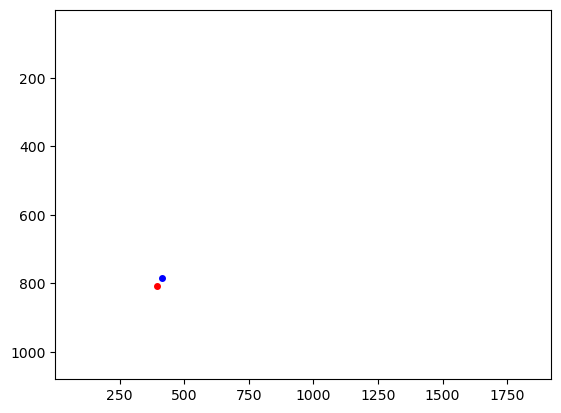

In [27]:
from tkinter import *
from matplotlib.figure import Figure
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import matplotlib.pyplot as plt

# Create a Tkinter window
root = Tk()
root.title("Marker Drawer")

# Create a Frame to hold the matplotlib plot
frame = Frame(root)
frame.pack()

# Create a matplotlib figure and axis
fig, ax = plt.subplots()

ax.set_xlim([1, 1920])
ax.set_ylim([1080, 1])

# Function to update the marker position based on the slider value
def update_marker(val):
    index = int(val)
    ax.clear()
    ax.set_xlim([1, 1920])
    ax.set_ylim([1080, 1])
    # Draw a marker on the canvas based on the x and y coordinates from the array
    x_left, y_left = data_1_1_1[index,2], data_1_1_1[index,4]
    x_right, y_right = data_1_1_1[index,3], data_1_1_1[index,5]
    ax.plot(x_left, y_left, marker='o', color='red', markersize=4)
    ax.plot(x_right, y_right, marker='o', color='blue', markersize=4)
    timeslot = data_1_1_1[index,6]*0.05
    x_,y_,timeslot_ = "{:.2f}".format(x_left),"{:.2f}".format(y_left),"{:.2f}".format(timeslot)
    value_label.config(text=f"Marker position: ({x_}, {y_}), video frame : {data_1_1_1[index,6]}, time {timeslot_}")
    fig.canvas.draw_idle()

# Create a slider
slider = Scale(root, from_=0, to=len(data_1_1_1) - 1, orient=HORIZONTAL, command=update_marker, length=300)
slider.pack()

# Create a label for additional information
value_label = Label(root, text="Marker position: (0, 0)")
value_label.pack()

# Show the initial plot
canvas = FigureCanvasTkAgg(fig, master=frame)
canvas.draw()
canvas.get_tk_widget().pack(side='top', fill='both', expand=1)

# Run the Tkinter event loop
root.mainloop()
